In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting
import datetime                   # library for date manipulation

from scipy.stats import norm
from scipy.interpolate import interp1d

from os import path

import sys
sys.path.append("../src/confer_wp3/")
from plotting import plot_fields                                    # function for visualizing spatial data in a map
from lasso_forecast import calculate_tercile_probability_forecasts

The following two variables specify the paths where the forecast and observation data are stored:

In [2]:
era5_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/raw_predictors/'
chirps_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/'
indices_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/'
anomaly_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/seasonal/halfdeg_res/'
eof_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/'
fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls_pred/chirps/seasonal/halfdeg_res/'

Now, we set a number of parameters defining our forecast domain, training period, forecast year, etc.:

In [3]:
year_clm_start = 1993     # first year of the climatological reference period
year_clm_end = 2020       # last year of the climatological reference period

year_train_start = 1981   # first year of the training period
year_train_end = 2020     # last year of the training period

year_fcst = 2020          # year in which forecasts should be generated
month_init = 8            # month in which the forecast should be generated (based on data of the preceding month)
season = 'OND'

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

period_clm = [year_clm_start, year_clm_end]
period_train = [year_train_start, year_train_end]

If not already available, load CHIRPS data, calculate seasonal precipitation anomalies, EOFs, and factor loading, and save out.

### Data loading

In [4]:
# Predictors: uwind200, uwind850, sst, chirps
# Dir: era5_dir or chirps_dir
    
def load_raw_data(dir, predictor, bounding_box, years, season=None):
    # Construct file path
    if predictor == "sst":
        pth = "sst/full.nc"
    elif predictor == "uwind200":
        pth = "uwind/200hpa/full.nc"
    elif predictor == "uwind850":
        pth = "uwind/850hpa/full.nc"
    elif predictor == "chirps":
        pth = "prec_raw.nc"
    file_path = f"{dir}{pth}"
    
     # Load data
    data = xr.open_dataset(file_path)
    
    if predictor == "chirps":
        # Subset data based on bounding box
        lon_min, lon_max, lat_min, lat_max = bounding_box
        data = data.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    
    # Subset data based on years
    data = data.sel(year=slice(years[0], years[-1]))
    
    # Aggregate by season if provided
    if predictor == "chirps" and season is not None:
        if season == 'OND':
            season_months = [10, 11, 12]
        elif season == 'MAM':
            season_months = [3, 4, 5]
        elif season == 'JJAS':
            season_months = [6, 7, 8, 9]
        data = data.sel(month=np.isin(data['month'], season_months))
        
        # Convert to NumPy array for easier manipulation
        data_np = data['prec'].values
        
        # Aggregate by summing over the selected months
        data = data.groupby('year').sum(dim='month', skipna=False)
    
    # Convert to NumPy arrays
    year = data['year'].values
    lon = data['lon'].values
    lat = data['lat'].values

    if predictor == "chirps":
        predictor_values = data['prec'].values # Shape: (year, lat, lon)
    elif predictor == "uwind200" or predictor == "uwind850":
        # #predictor_values = data['uwind'].values
        # month = data['month'].values
        # return year, lon, lat, month
        return data
    elif predictor == "sst":
        # #predictor_values = data['sst'].values
        # month = data['month'].values
        # return year, lon, lat, month
        return data
    
    return year, lon, lat, predictor_values

#### Loading tests

In [5]:
# ecmwf_data = xr.open_dataset(f"/nr/samba/PostClimDataNoBackup/CONFER/EASP/ecmwf/precip_new.nc", engine='netcdf4')
# ecmwf_data

### CHIRPS DATA

Raw CHIRPS data:  
(year, month, lon, lat, prec)  
year 1981 - 2023   
month 1-12  
lat -11.5 to 21.5  
lon 22.0 to 51.0  
one prec value for each combination of the four above  

##### Loading data

In [6]:
# TESTING
test_dir = "/nr/samba/user/ahellevik/CONFER-WP3/testdata/"

# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
year, lon, lat, prec_data = load_raw_data(chirps_dir, "chirps", box, [i for i in range(year_train_start, year_train_end+1)], season=season) # 1993, 2021
prec_data.shape
print("Loaded data shape:", prec_data.shape)
print("NaN values in loaded data:", np.isnan(prec_data).sum())

Loaded data shape: (40, 67, 59)
NaN values in loaded data: 76200


##### Calculate anomalies

In [7]:
# Restrict to the geographical bounds
lon_mask = (lon >= lon_bnds[0]) & (lon <= lon_bnds[1])
lat_mask = (lat >= lat_bnds[0]) & (lat <= lat_bnds[1])

lon = lon[lon_mask]
lat = lat[lat_mask]
prec_data = prec_data[:, lat_mask, :][:, :, lon_mask]

# Select the reference period using a boolean mask
ref_period_mask = (year >= year_clm_start) & (year <= year_clm_end)
ref_period_indices = np.where(ref_period_mask)[0]

# Calculate climatology (mean over the reference period)
climatology = np.nanmean(prec_data[ref_period_indices, :, :], axis=0)

# Calculate anomalies by subtracting climatology
anomalies = prec_data - climatology[np.newaxis, :, :]

print(prec_data.shape)
print(anomalies.shape)
# Verify NaNs are handled correctly
print("NaN values in prec_data:", np.isnan(prec_data).sum())
print("NaN values in anomalies:", np.isnan(anomalies).sum())

(40, 67, 59)
(40, 67, 59)
NaN values in prec_data: 76200
NaN values in anomalies: 76200


/tmp/ipykernel_4049216/949136485.py:14: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(prec_data[ref_period_indices, :, :], axis=0)


##### Visualize calculation of anomalies for a random month/year pair

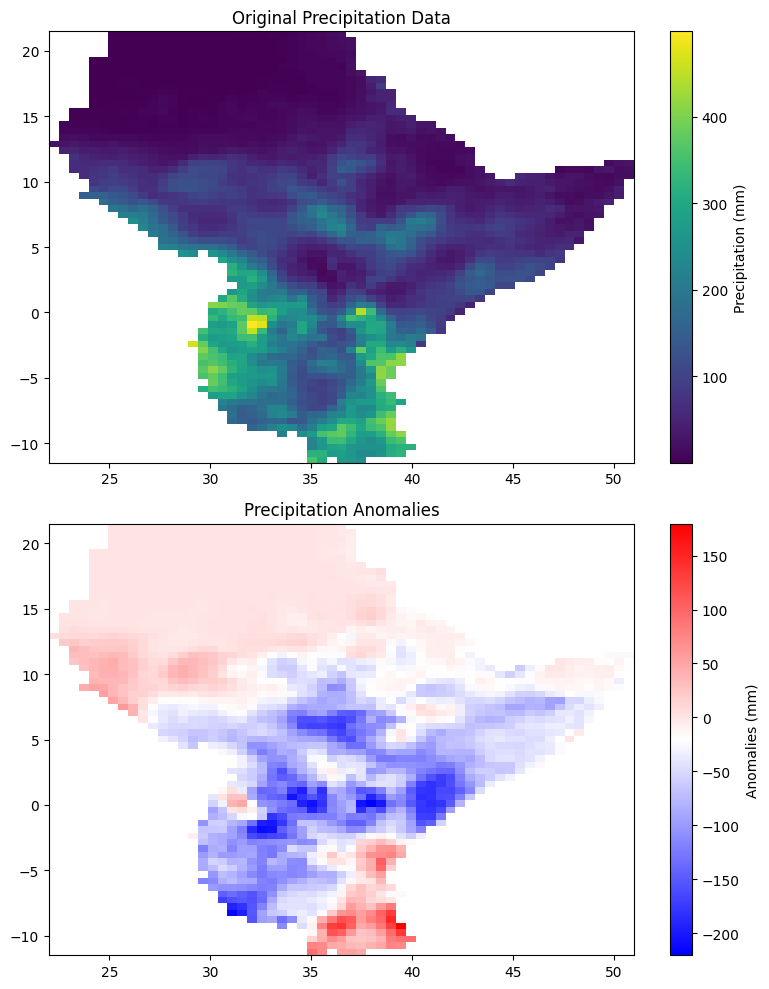

In [8]:
# Plot original precipitation data
plt.figure(figsize=(8, 10))  # Adjusting figsize for a more even aspect ratio
plt.subplot(2, 1, 1)
plt.title('Original Precipitation Data')
plt.imshow(prec_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='viridis', aspect='auto')
plt.colorbar(label='Precipitation (mm)')

# Plot anomalies
plt.subplot(2, 1, 2)
plt.title('Precipitation Anomalies')
plt.imshow(anomalies[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='bwr', aspect='auto')
plt.colorbar(label='Anomalies (mm)')
plt.tight_layout()
plt.show()

##### Transform anomalies to normal dist. using quantile mapping

In [9]:
def quantile_mapping(data, ref_indices):
    transformed_data = np.full_like(data, np.nan)
    
    # Standard deviation for the reference period at each grid point
    ref_period_std = np.nanstd(data[ref_indices, :, :], axis=0)
    
    for lat_idx in range(data.shape[1]):
        for lon_idx in range(data.shape[2]):
            ref_data = data[ref_indices, lat_idx, lon_idx]
            ref_data_valid = ref_data[~np.isnan(ref_data)]
            
            if ref_data_valid.size == 0:
                continue
            
            # Add small noise to avoid identical ranks
            ref_data_valid += abs(np.random.normal(0, 1e-10, ref_data_valid.shape))

            # Sort the reference data and calculate percentiles
            sorted_ref_data = np.sort(ref_data_valid)
            # Add small jitter to avoid repeated values
            jitter = np.random.normal(0, 1e-10, sorted_ref_data.shape)
            sorted_ref_data_jittered = sorted_ref_data + abs(jitter)
            n = ref_data_valid.size
            ref_percentiles = np.arange(1, n + 1) / (n + 1)
            
            # Calculate the normal scores for the percentiles
            ref_normal = norm.ppf(ref_percentiles)
            ref_min_outside_range = norm.ppf(1/(n+2))
            ref_max_outside_range = norm.ppf((n+1)/(n+2))

            # Interpolator for reference period quantiles
            interp_func = interp1d(sorted_ref_data_jittered, ref_normal, kind='linear', bounds_error=False, fill_value=(ref_min_outside_range, ref_max_outside_range))
            #interp_func = interp1d(sorted_ref_data_jittered, ref_normal, kind='linear', fill_value="extrapolate", bounds_error=False)
            
            all_years_data = data[:, lat_idx, lon_idx]
            valid_mask = ~np.isnan(all_years_data) 
            all_years_data_valid = all_years_data[valid_mask]
            
            # Add jitter to all_years_data_valid
            all_years_data_valid += np.random.normal(0, 1e-10, all_years_data_valid.shape)
            
            # Interpolation of normal quantiles using reference period
            all_years_normal = interp_func(all_years_data_valid)

            # Standardize the normal values using the reference period standard deviation
            all_years_normal_standardized = all_years_normal * ref_period_std[lat_idx, lon_idx]
            
            # Place standardized values back in the original array shape
            transformed_data[valid_mask, lat_idx, lon_idx] = all_years_normal_standardized
            #transformed_data[valid_mask, lat_idx, lon_idx] = all_years_normal
            # Check for any new NaNs introduced
            if np.isnan(transformed_data[:, lat_idx, lon_idx]).sum() > np.isnan(data[:, lat_idx, lon_idx]).sum():
                print(f"New NaNs introduced at grid point (lat: {lat_idx}, lon: {lon_idx})")
                print(f"Original NaNs: {np.isnan(data[:, lat_idx, lon_idx]).sum()}")
                print(f"Transformed NaNs: {np.isnan(transformed_data[:, lat_idx, lon_idx]).sum()}")
                print(f"ref_data_valid: {ref_data_valid}")
                print(f"sorted_ref_data: {sorted_ref_data}")
                print(f"ref_percentiles: {ref_percentiles}")
                print(f"ref_normal: {ref_normal}")
                print(f"all_years_data_valid: {all_years_data_valid}")
                print(f"all_years_normal: {all_years_normal}")
                #print(f"all_years_normal_standardized: {all_years_normal_standardized}")
            
    return transformed_data

In [10]:
# Apply the transformation to the anomalies data
anomalies_normal = quantile_mapping(anomalies, ref_period_indices)
print(anomalies_normal.shape)

/nr/samba/user/ahellevik/CONFER-WP3/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(40, 67, 59)


In [11]:
# Saving, if wanted

# Convert to xarray DataArray for saving as NetCDF
anomalies_xr = xr.DataArray(anomalies, coords=[year, lat, lon], dims=['year', 'lat', 'lon'])
anomalies_normal_xr = xr.DataArray(anomalies_normal, coords=[year, lat, lon], dims=['year', 'lat', 'lon'])

# Save the anomalies and transformed anomalies
anomalies_xr.to_netcdf(f"{test_dir}/chirps_anomalies.nc")
anomalies_normal_xr.to_netcdf(f"{test_dir}/chirps_anomalies_normal.nc")

##### Plots to ensure processing anomalies went well

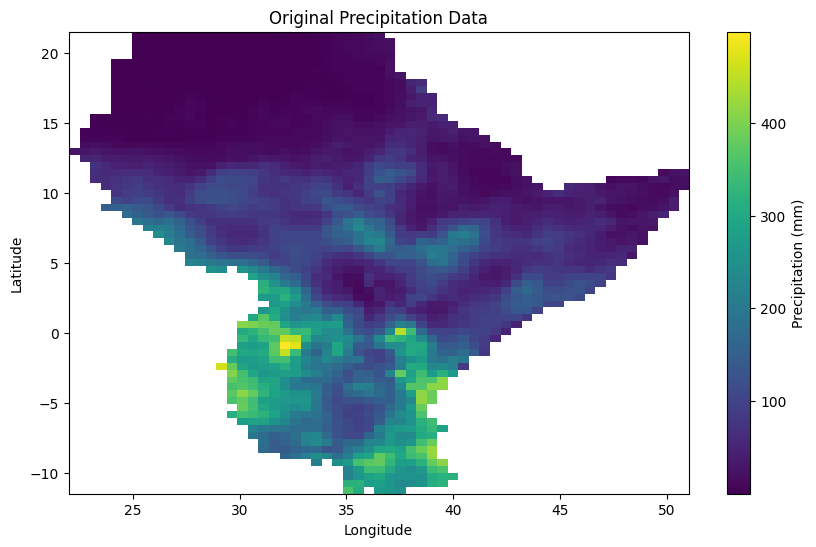

In [12]:
selected_year = 0  # First year in the dataset

plt.figure(figsize=(10, 6))
plt.title('Original Precipitation Data')
plt.imshow(prec_data[selected_year, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='viridis', aspect='auto')
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

337.5006


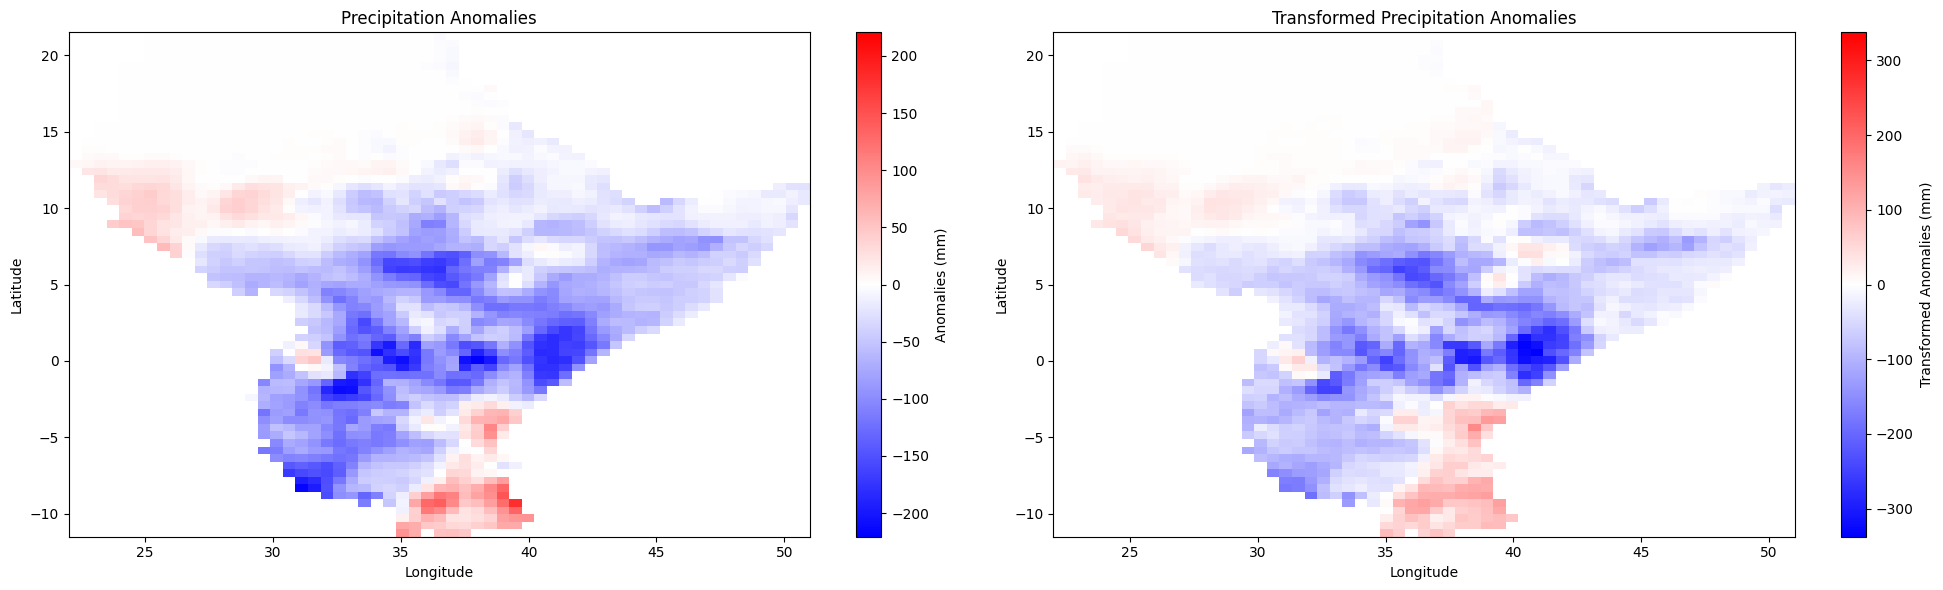

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

pltrg1 = np.nanmax(abs(anomalies[selected_year, :, :]))
# Plot Precipitation Anomalies
axes[0].set_title('Precipitation Anomalies')
img1 = axes[0].imshow(anomalies[selected_year, :, :], origin='lower', 
                      extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
                      cmap='bwr', aspect='auto', vmin=-pltrg1, vmax=pltrg1)
fig.colorbar(img1, ax=axes[0], label='Anomalies (mm)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot Transformed Precipitation Anomalies
axes[1].set_title('Transformed Precipitation Anomalies')

pltrg = np.nanmax(abs(anomalies_normal[selected_year, :, :]))
print(pltrg)

img2 = axes[1].imshow(anomalies_normal[selected_year, :, :], origin='lower', 
                      extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
                      cmap='bwr', aspect='auto', vmin=-pltrg, vmax=pltrg)
fig.colorbar(img2, ax=axes[1], label='Transformed Anomalies (mm)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


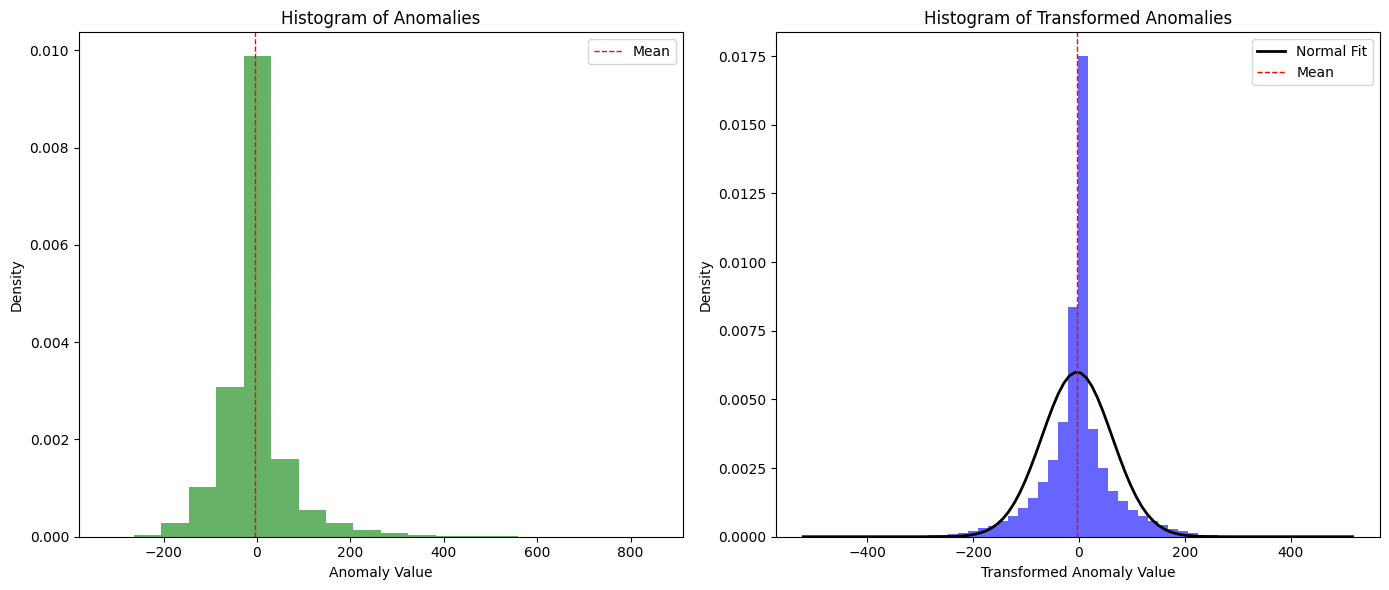

In [14]:
# Flatten the arrays and filter out non-finite values
anomalies_flat = anomalies[:, :, :].flatten()
anomalies_normal_flat = anomalies_normal[:, :, :].flatten()
#plt.hist(anomalies_normal_flat[~np.isnan(anomalies_normal_flat)], bins = 1000)
# Remove non-finite values
anomalies_flat = anomalies_flat[np.isfinite(anomalies_flat)]
anomalies_normal_flat = anomalies_normal_flat[~np.isnan(anomalies_normal_flat)]

plt.figure(figsize=(14, 6))

# Original anomalies histogram
plt.subplot(1, 2, 1)
plt.hist(anomalies_flat, bins=20, density=True, alpha=0.6, color='g')
plt.title('Histogram of Anomalies')
plt.xlabel('Anomaly Value')
plt.ylabel('Density')
plt.axvline(np.mean(anomalies_flat), color='r', linestyle='dashed', linewidth=1)
plt.legend(['Mean'])

# Transformed anomalies histogram
plt.subplot(1, 2, 2)
plt.hist(anomalies_normal_flat, bins=50, density=True, alpha=0.6, color='b')

# Overlay normal distribution curve
mu, std = norm.fit(anomalies_normal_flat)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Histogram of Transformed Anomalies')
plt.xlabel('Transformed Anomaly Value')
plt.ylabel('Density')
plt.axvline(mu, color='r', linestyle='dashed', linewidth=1)
plt.legend(['Normal Fit', 'Mean'])

plt.tight_layout()
plt.show()

In [15]:
print("Anomalies - mean:", np.nanmean(anomalies), "std:", np.nanstd(anomalies))
print("Transformed Anomalies - mean:", np.nanmean(anomalies_normal), "std:", np.nanstd(anomalies_normal))

# Check for any inf values
print("Inf values in anomalies:", np.isinf(anomalies).sum())
print("Inf values in transformed anomalies:", np.isinf(anomalies_normal).sum())

# Check for any nan values
print("NaN values in anomalies:", np.isnan(anomalies).sum())
print("NaN values in transformed anomalies:", np.isnan(anomalies_normal).sum())


Anomalies - mean: -3.7547219 std: 70.4129
Transformed Anomalies - mean: -3.552187 std: 66.52931
Inf values in anomalies: 0
Inf values in transformed anomalies: 0
NaN values in anomalies: 76200
NaN values in transformed anomalies: 76200


##### Calculate EOFs

In [16]:
from eofs.standard import Eof

In [17]:
def compute_eofs_pcs(data, n_eofs = None):
    # Mask invalid values
    data_masked = np.ma.masked_invalid(data)
    
    # Initialize the EOF solver
    solver = Eof(data_masked)
    
    # Calculate the EOFs and PCs
    eofs = solver.eofs(neofs=n_eofs)
    pcs = solver.pcs(npcs=n_eofs)
    variance_fraction = solver.varianceFraction(neigs=n_eofs)
    
    return eofs, pcs, variance_fraction

In [18]:
# Reshape the data to 2D (time, space) for EOF computation
year, lat, lon = anomalies.shape
anomalies_reshaped_2D = anomalies.reshape(year, lat * lon)
anomalies_normal_reshaped_2D = anomalies_normal.reshape(year, lat * lon)


n_eofs = 6  # Number of EOFs to compute
eofs_anomalies, pcs_anomalies, var_frac_anomalies = compute_eofs_pcs(anomalies_reshaped_2D, n_eofs=n_eofs)
eofs_ano_normal, pcs_ano_normal, var_frac_ano_normal = compute_eofs_pcs(anomalies_normal_reshaped_2D, n_eofs=n_eofs)

print("Anomalies EOFs Shape:", eofs_anomalies.shape)
print("Anomalies PCs Shape:", pcs_anomalies.shape)
print("Anomalies Variance Fraction:", var_frac_anomalies)
print("Normalized Anomalies EOFs Shape:", eofs_ano_normal.shape)
print("Normalized Anomalies PCs Shape:", pcs_ano_normal.shape)
print("Normalized Anomalies Variance Fraction:", var_frac_ano_normal)

Anomalies EOFs Shape: (6, 3953)
Anomalies PCs Shape: (40, 6)
Anomalies Variance Fraction: [0.64271367 0.08839291 0.04452832 0.03334996 0.02675198 0.01849894]
Normalized Anomalies EOFs Shape: (6, 3953)
Normalized Anomalies PCs Shape: (40, 6)
Normalized Anomalies Variance Fraction: [0.5827638  0.08880082 0.06480564 0.04040317 0.02758798 0.02057269]


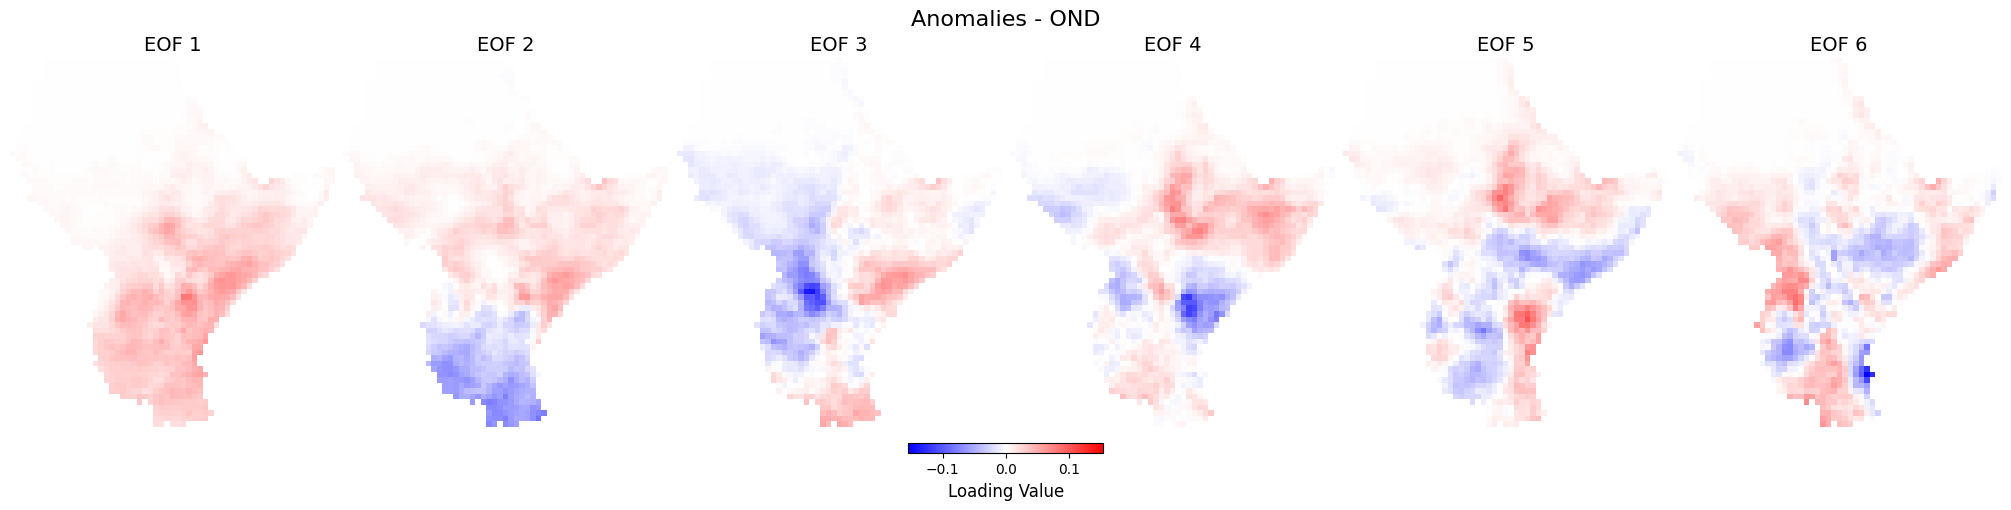

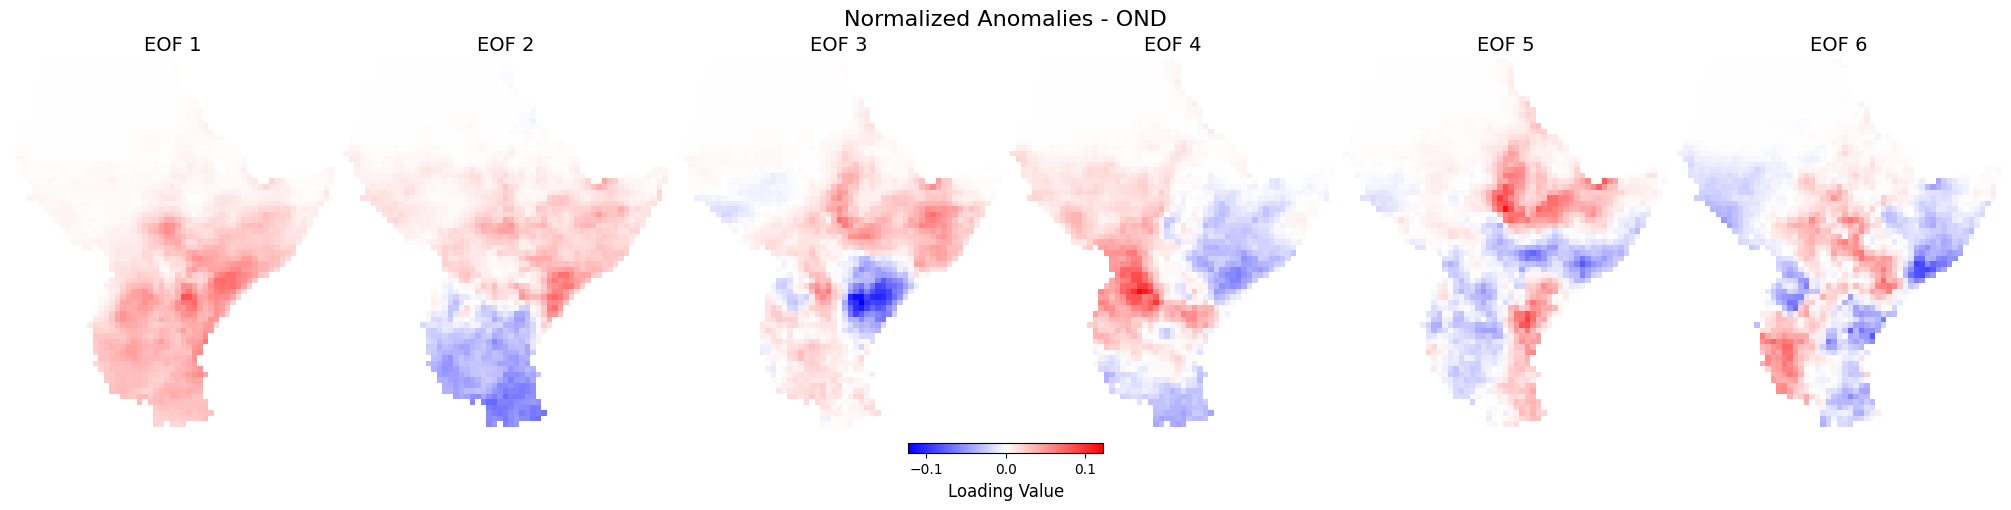

In [19]:
# Reshape the EOFs back to the original spatial dimensions
eofs_anomalies_reshaped = eofs_anomalies.reshape(n_eofs, lat, lon)
eofs_norm_anomalies_reshaped = eofs_ano_normal.reshape(n_eofs, lat, lon)

# Plotting function
def plot_eofs(eofs, title, n_eofs = 1, cmap='bwr'):
    fig, axes = plt.subplots(1, n_eofs, figsize=(20, 5), constrained_layout=True)
    
    vmin, vmax = -np.max(abs(eofs)), np.max(abs(eofs))
    
    for col in range(n_eofs):
        ax = axes[col]
        # Flip the EOF arrays vertically
        flipped_eof = np.flipud(eofs[col])
        im = ax.imshow(flipped_eof, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)
        ax.set_title(f'EOF {col + 1}', fontsize=14)
        ax.axis('off')
    
    cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.025, pad=0.04)
    cbar.set_label('Loading Value', fontsize=12)
    
    plt.suptitle(title, fontsize=16)
    plt.show()
    
# Plot EOFs for anomalies
plot_eofs(eofs_anomalies_reshaped, 'Anomalies - OND', n_eofs=n_eofs)

# Plot EOFs for normalized anomalies
plot_eofs(eofs_norm_anomalies_reshaped, 'Normalized Anomalies - OND', n_eofs=n_eofs)

##### Get Factor Loadings

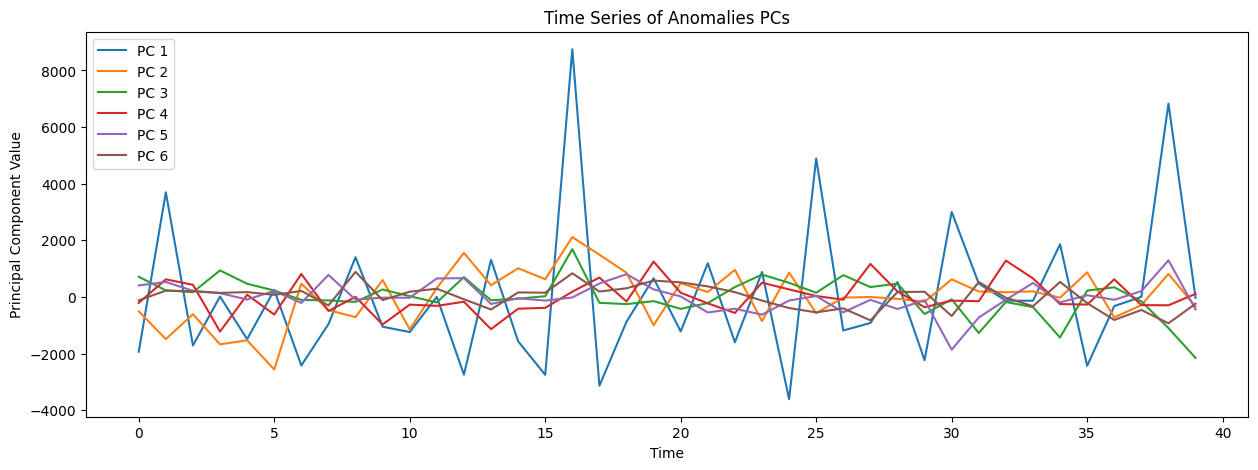

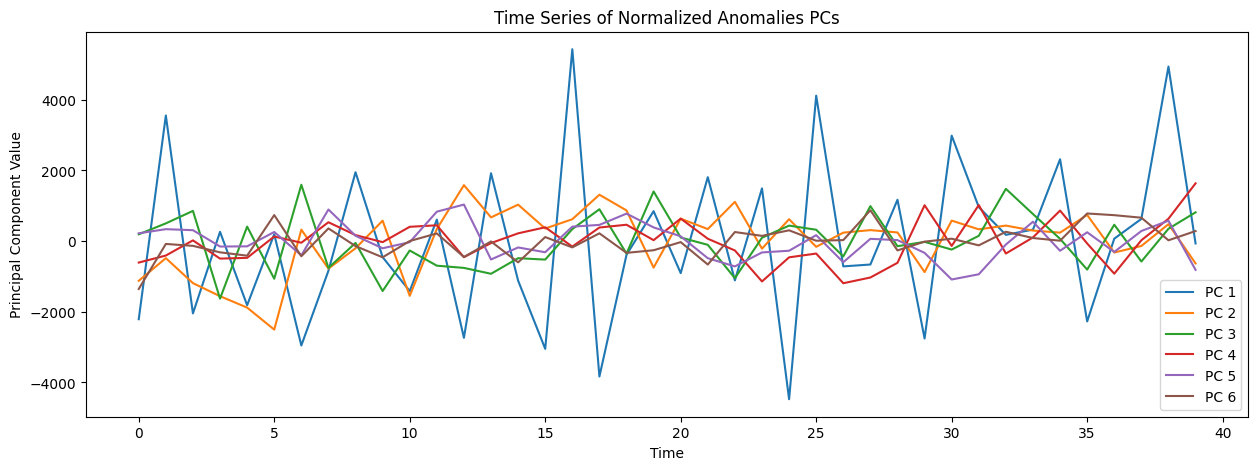

In [20]:
# Function to plot time series of the principal components
def plot_pcs_time_series(pcs, title, size = (15, 5)):
    plt.figure(figsize=size)
    for i in range(pcs.shape[1]):
        plt.plot(pcs[:, i], label=f'PC {i+1}')
    plt.title(f'Time Series of {title}')
    plt.xlabel('Time')
    plt.ylabel('Principal Component Value')
    plt.legend()
    plt.show()

# Plot time series of principal components
plot_pcs_time_series(pcs_anomalies, 'Anomalies PCs')
plot_pcs_time_series(pcs_ano_normal, 'Normalized Anomalies PCs')

In [21]:
# Manual calculation of time series
# NaN handling

# Fill NaNs with 0
anomalies_normal_reshaped_2D_filled = np.nan_to_num(anomalies_normal_reshaped_2D, nan=0.0)
# Fill NaNs in eofs_ano_normal with 0
eofs_ano_normal_filled = np.nan_to_num(eofs_ano_normal, nan=0.0)

pcs_ano_normal_manual = np.dot(anomalies_normal_reshaped_2D_filled, eofs_ano_normal_filled.T)
# Verify the result
print("Shape of pcs_ano_normal_manual:", pcs_ano_normal_manual.shape)

Shape of pcs_ano_normal_manual: (40, 6)


In [22]:
# Get and plot reference time series

filepath_fls = f'/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/chirps/seasonal/halfdeg_res/refper_1993-2020/prec_full_{season}.csv'
data_prec_full = pd.read_csv(filepath_fls)

# Select the rows where loy equals 1981
selected_loy = 1981
data_prec = data_prec_full[data_prec_full['loy'] == selected_loy]

# Filter data to only include the first n_eofs EOFs
data_prec = data_prec[data_prec['eof'] <= n_eofs]

# Specify the years and EOFs to extract 
train_period = np.arange(year_train_start, year_train_end+1) 
selected_years = train_period

# Extract 'fl' and 'sfl' values and reshape the data to (year, n_eofs)
fl_values = data_prec.pivot(index='year', columns='eof', values='fl').reindex(selected_years, fill_value=np.nan).values
sfl_values = data_prec.pivot(index='year', columns='eof', values='sfl').reindex(selected_years, fill_value=np.nan).values
print(fl_values.shape)
print(sfl_values.shape)


(40, 6)
(40, 6)


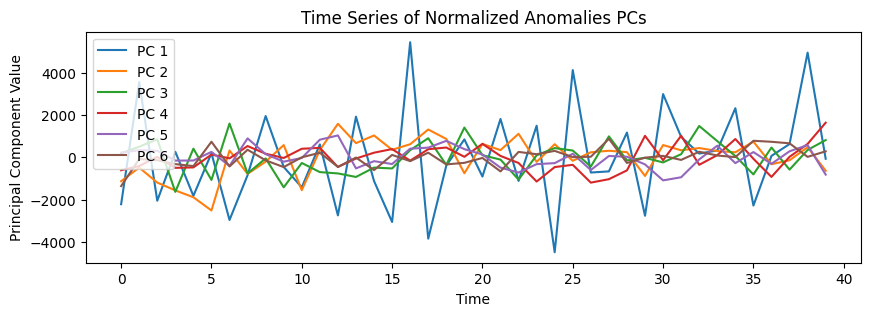

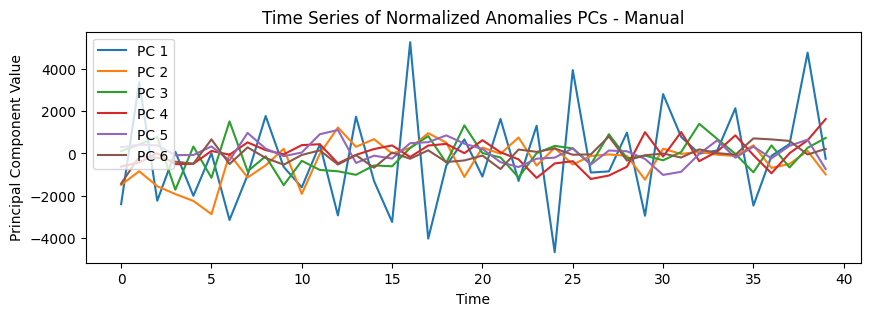

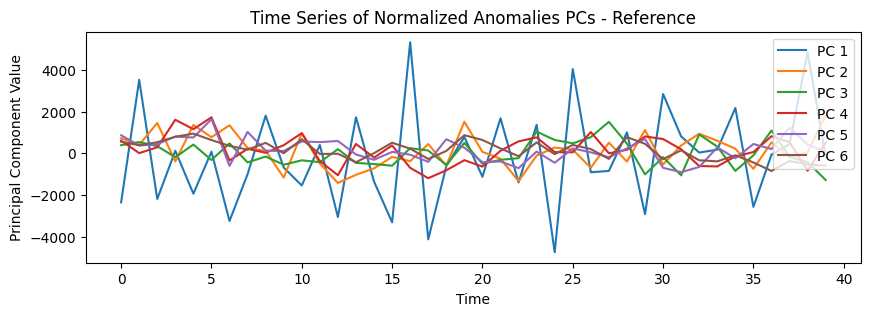

In [23]:
# Plotting normalized anomalies time series
plot_pcs_time_series(pcs_ano_normal, 'Normalized Anomalies PCs', size = (10, 3))

# Plotting manually calculated normalized anomalies time series
plot_pcs_time_series(pcs_ano_normal_manual, 'Normalized Anomalies PCs - Manual', size = (10, 3))

# Plotting reference normalized anomalies time series
plot_pcs_time_series(fl_values, 'Normalized Anomalies PCs - Reference', size = (10, 3))

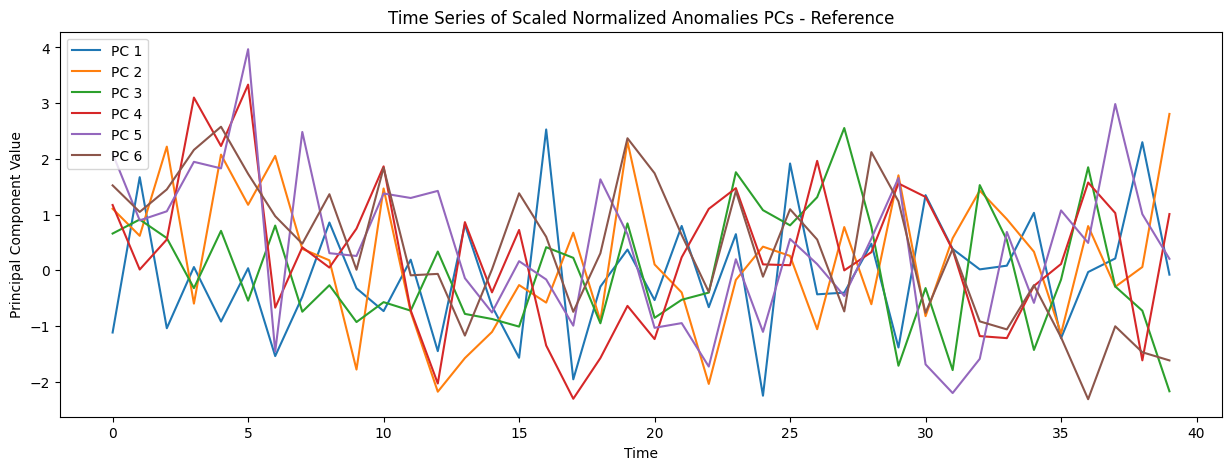

In [24]:
# Plotting reference scaled normalized anomalies time series
plot_pcs_time_series(sfl_values, 'Scaled Normalized Anomalies PCs - Reference')

In [25]:
# def calculate_factor_loadings(anomalies, eofs, train_period):
#     n_years, n_lat, n_lon = anomalies.shape
#     n_eofs = eofs.shape[0]
    
#     # Initialize arrays to store factor loadings, d, and sfl
#     fl_array = np.zeros((n_years, n_eofs))
#     d_array = np.zeros((n_years, n_eofs))
#     sfl_array = np.zeros((n_years, n_eofs))

#     # Print norms of EOFs to check if they are normalized
#     for eof_idx in range(n_eofs):
#         norm_value = np.linalg.norm(eofs[eof_idx])
#         print(f"Norm of EOF {eof_idx + 1}: {norm_value}")
#     for year_idx in range(n_years):
#         for eof_idx in range(n_eofs):
#             eof = eofs[eof_idx]
#             anomaly = anomalies[year_idx]

#             # Replace NaNs with zeros for calculations
#             eof = np.nan_to_num(eof, nan=0.0)
#             anomaly = np.nan_to_num(anomaly, nan=0.0)
            
#             # Calculate the factor loading for this year and EOF mode
#             fl = np.nansum(anomaly * eof)
#             d = np.linalg.norm(eof)  # This is analogous to the eigenvalue scaling in the R code
#             print(d)
#             # Avoid division by zero
#             if d != 0:
#                 # Calculate the scaled factor loading
#                 sfl = (np.sqrt(len(train_period) - 1) * fl) / d  # Use the length of the training period for scaling
#             else:
#                 sfl = np.nan
            
#             # Store the results in arrays
#             fl_array[year_idx, eof_idx] = fl
#             d_array[year_idx, eof_idx] = d
#             sfl_array[year_idx, eof_idx] = sfl
    
#     return fl_array, d_array, sfl_array

In [26]:
# Define the train period 
# train_period = np.arange(year_train_start, year_train_end+1) 

# # Calculate the factor loadings
# fl_array, d_array, sfl_array = calculate_factor_loadings(anomalies_normal, eofs_norm_anomalies_reshaped, train_period)
# print(sfl_array.shape)
# print(sfl_array)

In [27]:
#plot_pcs_time_series(sfl_array, 'Scaled Normalized Anomalies PCs')

In [28]:
# Create xarray Dataset
ds = xr.Dataset(
    {
        'fl': (('year', 'eof'), pcs_ano_normal),
        # 'd': (('year', 'eof'), d_array),
        # 'sfl': (('year', 'eof'), sfl_array),
    },
    coords={
        'year': train_period,
        'eof': np.arange(1, eofs_norm_anomalies_reshaped.shape[0] + 1)
    }
)

# Save to NetCDF file
ds.to_netcdf(f"{test_dir}/fls.nc")
print(f"Factor loadings saved to {test_dir}")

Factor loadings saved to /nr/samba/user/ahellevik/CONFER-WP3/testdata/


In [29]:
#filename_pct_target = f'{percentile_dir}percentiles_{target}_{year_train_start}_{year_train_end}.nc'

#if not path.exists(filename_pct_target):
#    calculate_target_percentiles(target, year_train_start, year_train_end, lon_bnds, lat_bnds, target_dir, filename_pct_target)

data_load = xr.open_dataset(f'{anomaly_dir}refper_{period_clm[0]}-{period_clm[1]}/precip_full_{season}.nc', engine='netcdf4')
lon = data_load.lon.values
lat = data_load.lat.values
data_load.close()

nlon = len(lon)
nlat = len(lat)

## ERA5

If not already available, load ERA5 data, calculate indices, and save out.

Do not use n3, n4.

### Loading data

In [30]:
# sst_data1 = xr.open_dataset(f"{era5_dir}/sst/full.nc") # Original dataset shape: (year, month, lon, lat) = (71, 12, 360, 169)

# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
load_years = [i for i in range(min(year_train_start, year_clm_start), max(year_train_end+1, year_clm_end+1))]
# Call the load_raw_data function
#sst_year, sst_lon, sst_lat, sst_month = load_raw_data(era5_dir, "sst", box, [i for i in range(year_train_start, year_train_end+1)], season=season)
#print(sst_year.shape, sst_month.shape, sst_lon.shape, sst_lat.shape)
sst_data = load_raw_data(era5_dir, "sst", box, load_years, season=season)
sst_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lon: 360, lat: 169)
Coordinates:
  * year     (year) int32 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -78.0 -77.0 -76.0 -75.0 -74.0 ... 87.0 88.0 89.0 90.0
Data variables:
    sst      (lat, lon, month, year) float32 ...

In [31]:
# uwind_200hpa_data_test = xr.open_dataset(f"{era5_dir}/uwind/200hpa/full.nc") # Original dataset shape: (year, month, lat, lon) = (74, 12, 361, 720)

# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
# Call the load_raw_data function
# uwind_200_year, uwind_200_lon, uwind_200_lat, uwind_200_month = load_raw_data(era5_dir, "uwind200", box, [i for i in range(year_train_start, year_train_end+1)], season=season)
# print(uwind_200_year.shape, uwind_200_month.shape, uwind_200_lon.shape, uwind_200_lat.shape)
uwind200_data = load_raw_data(era5_dir, "uwind200", box, [i for i in range(year_train_start, year_train_end+1)], season=season)
uwind200_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

In [32]:
# uwind_850hpa_data_test = xr.open_dataset(f"{era5_dir}/uwind/850hpa/full.nc") # Original dataset shape: (year, month, lat, lon) = (74, 12, 361, 720)

# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
# Call the load_raw_data function
# uwind_850_year, uwind_850_lon, uwind_850_lat, uwind_850_month = load_raw_data(era5_dir, "uwind850", box, [i for i in range(year_train_start, year_train_end+1)], season=season)
# print(uwind_850_year.shape, uwind_850_month.shape, uwind_850_lon.shape, uwind_850_lat.shape)
uwind850_data = load_raw_data(era5_dir, "uwind850", box, [i for i in range(year_train_start, year_train_end+1)], season=season)
uwind850_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

### Calculate indices

In [33]:
# Define the bounding boxes for the indices
indices_definitions = {
    'n34': {'lat_min': -5, 'lat_max': 5, 'lon_min': -170, 'lon_max': -120},
    'n3': {'lat_min': -5, 'lat_max': 5, 'lon_min': -150, 'lon_max': -90},
    'n4_1': {'lat_min': -5, 'lat_max': 5, 'lon_min': -180, 'lon_max': -150},
    'n4_2': {'lat_min': -5, 'lat_max': 5, 'lon_min': 160, 'lon_max': 180},
    'wpg': {'lat_min': 0, 'lat_max': 20, 'lon_min': 130, 'lon_max': 150},
    'dmi_west': {'lat_min': -10, 'lat_max': 10, 'lon_min': 50, 'lon_max': 70},
    'dmi_east': {'lat_min': -10, 'lat_max': 0, 'lon_min': 90, 'lon_max': 110},
    'ueq850': {'lat_min': -4, 'lat_max': 4, 'lon_min': 60, 'lon_max': 90},
    'ueq200': {'lat_min': -4, 'lat_max': 4, 'lon_min': 60, 'lon_max': 90},
    'wp' : {'lat_min': -15, 'lat_max': 20, 'lon_min': 120, 'lon_max': 160},
    'wnp_1' : {'lat_min': 20, 'lat_max': 35, 'lon_min': 160, 'lon_max': 180},
    'wnp_2' : {'lat_min': 20, 'lat_max': 35, 'lon_min': -180, 'lon_max': -150},
    'wsp_1' : {'lat_min': -30, 'lat_max': -15, 'lon_min': 155, 'lon_max': 180}, 
    'wsp_2' : {'lat_min': -30, 'lat_max': -15, 'lon_min': -180, 'lon_max': -150},
}

##### Verifying index calculations

In [34]:
def standardize_index(data, index_name, indices_definitions = indices_definitions, period_clm = period_clm, year_fcst = year_fcst, month_init = month_init):
    # Calculate the index for the entire dataset
    if index_name in ["n4", "wnp", "wsp"]: 
        region1 = indices_definitions[f"{index_name}_1"]
        region2 = indices_definitions[f"{index_name}_2"]
        subset1 = data.sel(lat=slice(region1['lat_min'], region1['lat_max']), lon=slice(region1['lon_min'], region1['lon_max']))
        subset2 = data.sel(lat=slice(region2['lat_min'], region2['lat_max']), lon=slice(region2['lon_min'], region2['lon_max']))
        combined_subset = xr.concat([subset1, subset2], dim='lat')
        index = combined_subset.mean(dim=['lat', 'lon'])
    else:
        region = indices_definitions[index_name]
        subset = data.sel(lat=slice(region['lat_min'], region['lat_max']), lon=slice(region['lon_min'], region['lon_max']))
        index = subset.mean(dim=['lat', 'lon'])

    # Select the reference period from the index
    ref_data = index.sel(year=slice(period_clm[0], period_clm[1]))

    # Calculate the climatology (mean) and standard deviation during the reference period
    climatology = ref_data.mean(dim=['year'])
    climatology_std = ref_data.std(dim=['year'])

    # Standardize the current data point based on data from previous month
    if month_init == 1:
        current_datapoint = index.sel(year = year_fcst-1, month = 12)
        climatology = climatology.sel(month = 12)
        climatology_std = climatology_std.sel(month = 12)
    else:
        current_datapoint = index.sel(year = year_fcst, month = month_init-1)
        climatology = climatology.sel(month = month_init-1)
        climatology_std = climatology_std.sel(month = month_init-1)
    
    anomalies = current_datapoint - climatology
    standardized_anomalies = anomalies / climatology_std
    
    return standardized_anomalies

In [35]:
def standardize_index_wpg(data, index_name, indices_definitions = indices_definitions, period_clm = period_clm, year_fcst = year_fcst, month_init = month_init):
    # Calculate the index for the entire dataset
    region_wp = indices_definitions[index_name]
    region_n4_1 = indices_definitions["n4_1"]
    region_n4_2 = indices_definitions["n4_2"]
    subset_wp = data.sel(lat=slice(region_wp['lat_min'], region_wp['lat_max']), lon=slice(region_wp['lon_min'], region_wp['lon_max']))
    subset_n4_1 = data.sel(lat=slice(region_n4_1['lat_min'], region_n4_1['lat_max']), lon=slice(region_n4_1['lon_min'], region_n4_1['lon_max']))
    subset_n4_2 = data.sel(lat=slice(region_n4_2['lat_min'], region_n4_2['lat_max']), lon=slice(region_n4_2['lon_min'], region_n4_2['lon_max']))
    combined_subset_n4 = xr.concat([subset_n4_1, subset_n4_2], dim='lat')
    
    index_wp = subset_wp.mean(dim=['lat', 'lon'])
    index_n4 = combined_subset_n4.mean(dim=['lat', 'lon'])

    # Calculate the difference between the indices
    index = index_n4 - index_wp

    # Select the reference period from the index
    ref_data = index.sel(year=slice(period_clm[0], period_clm[1]))

    # Calculate the climatology (mean) and standard deviation during the reference period
    climatology = ref_data.mean(dim=['year'])
    climatology_std = ref_data.std(dim=['year'])

    # Standardize the current data point based on data from previous month
    if month_init == 1:
        current_datapoint = index.sel(year = year_fcst-1, month = 12)
        climatology = climatology.sel(month = 12)
        climatology_std = climatology_std.sel(month = 12)
    else:
        current_datapoint = index.sel(year = year_fcst, month = month_init-1)
        climatology = climatology.sel(month = month_init-1)
        climatology_std = climatology_std.sel(month = month_init-1)
    
    anomalies = current_datapoint - climatology
    standardized_anomalies = anomalies / climatology_std
    
    return standardized_anomalies

In [36]:
def standardize_index_dmi(data, index_name, indices_definitions = indices_definitions, period_clm = period_clm, year_fcst = year_fcst, month_init = month_init):
    # Calculate the index for the entire dataset
    region_dmi_west = indices_definitions["dmi_west"]
    region_dmi_east = indices_definitions["dmi_east"]
    subset_dmi_west = data.sel(lat=slice(region_dmi_west['lat_min'], region_dmi_west['lat_max']), lon=slice(region_dmi_west['lon_min'], region_dmi_west['lon_max']))
    subset_dmi_east = data.sel(lat=slice(region_dmi_east['lat_min'], region_dmi_east['lat_max']), lon=slice(region_dmi_east['lon_min'], region_dmi_east['lon_max']))

    index_dmi_west = subset_dmi_west.mean(dim=['lat', 'lon'])
    index_dmi_east = subset_dmi_east.mean(dim=['lat', 'lon'])

    # Calculate the difference between the indices
    index = index_dmi_west - index_dmi_east

    # Select the reference period from the index
    ref_data = index.sel(year=slice(period_clm[0], period_clm[1]))

    # Calculate the climatology (mean) and standard deviation during the reference period
    climatology = ref_data.mean(dim=['year'])
    climatology_std = ref_data.std(dim=['year'])

    # Standardize the current data point based on data from previous month
    if month_init == 1:
        current_datapoint = index.sel(year = year_fcst-1, month = 12)
        climatology = climatology.sel(month = 12)
        climatology_std = climatology_std.sel(month = 12)
    else:
        current_datapoint = index.sel(year = year_fcst, month = month_init-1)
        climatology = climatology.sel(month = month_init-1)
        climatology_std = climatology_std.sel(month = month_init-1)
    
    anomalies = current_datapoint - climatology
    standardized_anomalies = anomalies / climatology_std
    
    return standardized_anomalies

In [37]:
def standardize_index_n34_diff1(data, index_name, indices_definitions = indices_definitions, period_clm = period_clm, year_fcst = year_fcst, month_init = month_init):
    # Calculate the index for the entire dataset
    region = indices_definitions[index_name]
    subset = data.sel(lat=slice(region['lat_min'], region['lat_max']), lon=slice(region['lon_min'], region['lon_max']))
    index = subset.mean(dim=['lat', 'lon'])

    # Select the reference period from the index
    ref_data = index.sel(year=slice(period_clm[0], period_clm[1]))

    # Calculate the differences for all 12 months, including January using December from the previous year
    diff_list = []
    
    for year in range(period_clm[0], period_clm[1] + 1):
        for month in range(1, 13):
            if month == 1:
                if year > period_clm[0]:  # Ensure we have the previous year's December data
                    current_value = ref_data.sel(year=year, month=1)
                    previous_value = ref_data.sel(year=year-1, month=12)
                    diff = (current_value - previous_value).assign_coords(year=year, month=month)
                    diff_list.append(diff)
            else:
                current_value = ref_data.sel(year=year, month=month)
                previous_value = ref_data.sel(year=year, month=month-1)
                diff = (current_value - previous_value).assign_coords(year=year, month=month)
                diff_list.append(diff)
    
    diff_data = xr.concat(diff_list, dim='time')
    climatology = diff_data.mean(dim='time')
    climatology_std = diff_data.std(dim='time')

    # Helper function to safely select the current and previous data points
    def safe_sel(data, year, month):
        try:
            return data.sel(year=year, month=month)
        except KeyError as e:
            print(f"KeyError: {e}. Year: {year}, Month: {month}")
            return None

    # Standardize the current data point based on data from the previous month
    if month_init == 1:
        current_datapoint = safe_sel(index, year_fcst, 1)
        previous_datapoint = safe_sel(index, year_fcst-1, 12)
    else:
        current_datapoint = safe_sel(index, year_fcst, month_init)
        previous_datapoint = safe_sel(index, year_fcst, month_init-1)

    # Calculate the difference between the current and previous month
    difference = current_datapoint - previous_datapoint

    anomalies = difference - climatology
    standardized_anomalies = anomalies / climatology_std
    
    return standardized_anomalies


In [38]:
def standardize_index_dmi_diff1(data, index_name, indices_definitions = indices_definitions, period_clm = period_clm, year_fcst = year_fcst, month_init = month_init):
    # Calculate the index for the entire dataset
    region_dmi_west = indices_definitions["dmi_west"]
    region_dmi_east = indices_definitions["dmi_east"]
    subset_dmi_west = data.sel(lat=slice(region_dmi_west['lat_min'], region_dmi_west['lat_max']), lon=slice(region_dmi_west['lon_min'], region_dmi_west['lon_max']))
    subset_dmi_east = data.sel(lat=slice(region_dmi_east['lat_min'], region_dmi_east['lat_max']), lon=slice(region_dmi_east['lon_min'], region_dmi_east['lon_max']))

    index_dmi_west = subset_dmi_west.mean(dim=['lat', 'lon'])
    index_dmi_east = subset_dmi_east.mean(dim=['lat', 'lon'])

    # Calculate the difference between the indices
    index = index_dmi_west - index_dmi_east

    # Select the reference period from the index
    ref_data = index.sel(year=slice(period_clm[0], period_clm[1]))

    # Calculate the differences for all 12 months, including January using December from the previous year
    diff_list = []
    
    
    for year in range(period_clm[0], period_clm[1] + 1):
        for month in range(1, 13):
            if month == 1:
                if year > period_clm[0]:  # Ensure we have the previous year's December data
                    current_value = ref_data.sel(year=year, month=1)
                    previous_value = ref_data.sel(year=year-1, month=12)
                    diff = (current_value - previous_value).assign_coords(year=year, month=month)
                    diff_list.append(diff)
            else:
                current_value = ref_data.sel(year=year, month=month)
                previous_value = ref_data.sel(year=year, month=month-1)
                diff = (current_value - previous_value).assign_coords(year=year, month=month)
                diff_list.append(diff)
    
    diff_data = xr.concat(diff_list, dim='time')
    climatology = diff_data.mean(dim='time')
    climatology_std = diff_data.std(dim='time')

    # Helper function to safely select the current and previous data points
    def safe_sel(data, year, month):
        try:
            return data.sel(year=year, month=month)
        except KeyError as e:
            print(f"KeyError: {e}. Year: {year}, Month: {month}")
            return None

    # Standardize the current data point based on data from the previous month
    if month_init == 1:
        current_datapoint = safe_sel(index, year_fcst, 1)
        previous_datapoint = safe_sel(index, year_fcst-1, 12)
    else:
        current_datapoint = safe_sel(index, year_fcst, month_init)
        previous_datapoint = safe_sel(index, year_fcst, month_init-1)

    # Calculate the difference between the current and previous month
    difference = current_datapoint - previous_datapoint

    anomalies = difference - climatology
    standardized_anomalies = anomalies / climatology_std
    
    return standardized_anomalies



In [39]:
# Test n34 index values
filepath_indices = f'/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/refper_1993-2020/indices/'
n34_index_reference = pd.read_csv(f"{filepath_indices}n34_full.csv")

forecast_year = year_fcst
for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "n34", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(n34_index_reference[(n34_index_reference["year"] == forecast_year-1) & (n34_index_reference["month"] == 12)].fl.values[0])
    else:
        print(n34_index_reference[(n34_index_reference["year"] == forecast_year) & (n34_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.3798713
Reference value:
0.372994201030477


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.52240413
Reference value:
0.513009703875565


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.46925625
Reference value:
0.460850765524855


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
0.6152685
Reference value:
0.604228159008709


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
0.6854148
Reference value:
0.673120277439877


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
-0.57031614
Reference value:
-0.559903053642305



In [40]:
# Test n34_diff1 index values
filepath_indices = f'/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/refper_1993-2020/indices/'
n34_diff1_index_reference = pd.read_csv(f"{filepath_indices}n34_diff1_full.csv")

forecast_year = year_fcst
for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index_n34_diff1(sst_data, "n34", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(n34_diff1_index_reference[(n34_diff1_index_reference["year"] == forecast_year-1) & (n34_diff1_index_reference["month"] == 12)].fl.values[0])
    else:
        print(n34_diff1_index_reference[(n34_diff1_index_reference["year"] == forecast_year) & (n34_diff1_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.07670676
Reference value:
-0.0056419748808896


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.09943255
Reference value:
0.140015502845088


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
1.3160077
Reference value:
-0.0521589383507099


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
1.2551019
Reference value:
0.143377393483854


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
-1.3084123
Reference value:
0.0688921184311683


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
-0.71787816
Reference value:
-1.23302333108

In [41]:
# Test n3 index values

n3_index_reference = pd.read_csv(f"{filepath_indices}n3_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "n3", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(n3_index_reference[(n3_index_reference["year"] == forecast_year-1) & (n3_index_reference["month"] == 12)].fl.values[0])
    else:
        print(n3_index_reference[(n3_index_reference["year"] == forecast_year) & (n3_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.20983759
Reference value:
0.206019603912169


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.24821377
Reference value:
0.243756788163554


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.13393371
Reference value:
0.13158023441094


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
0.18719517
Reference value:
0.183879605622572


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
0.6145196
Reference value:
0.603480354458397


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
-0.3637926
Reference value:
-0.357162856612118



In [42]:
# Test n4 index values

n4_index_reference = pd.read_csv(f"{filepath_indices}n4_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "n4", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(n4_index_reference[(n4_index_reference["year"] == forecast_year-1) & (n4_index_reference["month"] == 12)].fl.values[0])
    else:
        print(n4_index_reference[(n4_index_reference["year"] == forecast_year) & (n4_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.8953215
Reference value:
0.879144916265894


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
1.0249
Reference value:
1.00643704571476


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
1.0707847
Reference value:
1.05155372046276


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
0.9801606
Reference value:
0.96257094914962


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
0.70644116
Reference value:
0.693796300287679


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
-0.039479565
Reference value:
-0.0386194564121859


Stan

In [43]:
# Test wpg index values

wpg_index_reference = pd.read_csv(f"{filepath_indices}wpg_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index_wpg(sst_data, "wpg", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(wpg_index_reference[(wpg_index_reference["year"] == forecast_year-1) & (wpg_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wpg_index_reference[(wpg_index_reference["year"] == forecast_year) & (wpg_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.6908258
Reference value:
0.8253758807116


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.7914261
Reference value:
1.02486499573251


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.7787176
Reference value:
0.952911481535054


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
0.5552804
Reference value:
0.481602647259719


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
0.2653129
Reference value:
0.0357678249028336


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
-0.34800646
Reference value:
-0.712856001388753


Sta

In [44]:
# Test dmi index values

dmi_index_reference = pd.read_csv(f"{filepath_indices}dmi_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index_dmi(sst_data, "dmi", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(dmi_index_reference[(dmi_index_reference["year"] == forecast_year-1) & (dmi_index_reference["month"] == 12)].fl.values[0])
    else:
        print(dmi_index_reference[(dmi_index_reference["year"] == forecast_year) & (dmi_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
1.68555
Reference value:
1.9418332171625


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.7422719
Reference value:
0.265314241227996


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
-0.12354872
Reference value:
0.343302725351841


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
-0.40194443
Reference value:
0.0886621333093891


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
-0.82182544
Reference value:
-0.28715540109203


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
0.8418015
Reference value:
0.715785616824016


S

In [45]:
# Test dmi_diff1 index values
filepath_indices = f'/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/refper_1993-2020/indices/'
dmi_diff1_index_reference = pd.read_csv(f"{filepath_indices}dmi_diff1_full.csv")

forecast_year = year_fcst
for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index_dmi_diff1(sst_data, "dmi", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(dmi_diff1_index_reference[(dmi_diff1_index_reference["year"] == forecast_year-1) & (dmi_diff1_index_reference["month"] == 12)].fl.values[0])
    else:
        print(dmi_diff1_index_reference[(dmi_diff1_index_reference["year"] == forecast_year) & (dmi_diff1_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
-1.5216116
Reference value:
-1.82678177870107


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
-0.19526683
Reference value:
-1.6765189759345


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.56636846
Reference value:
0.0779884841238445


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
0.78740245
Reference value:
-0.254640592042452


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
0.395202
Reference value:
-0.375817534401419


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
-1.0185668
Reference value:
1.00294101791605


In [46]:
# Test wp index values

wp_index_reference = pd.read_csv(f"{filepath_indices}wp_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "wp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(wp_index_reference[(wp_index_reference["year"] == forecast_year-1) & (wp_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wp_index_reference[(wp_index_reference["year"] == forecast_year) & (wp_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.403623
Reference value:
0.3965014406094


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.56273925
Reference value:
0.552468608350522


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.65793574
Reference value:
0.645874754009963


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
1.0894145
Reference value:
1.06964466368143


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
1.0633959
Reference value:
1.0440540742298


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
0.90789163
Reference value:
0.891268230984433


Standar

In [47]:
# Test wsp index values

wsp_index_reference = pd.read_csv(f"{filepath_indices}wsp_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "wsp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(wsp_index_reference[(wsp_index_reference["year"] == forecast_year-1) & (wsp_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wsp_index_reference[(wsp_index_reference["year"] == forecast_year) & (wsp_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.026800456
Reference value:
0.0263166023317855


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
-0.2280746
Reference value:
-0.223977062664927


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.61174434
Reference value:
0.600790106588463


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
1.2746162
Reference value:
1.25162967063952


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
1.0066546
Reference value:
0.988529011287948


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
1.2496468
Reference value:
1.22721987566164




In [48]:
# Test wnp index values

wnp_index_reference = pd.read_csv(f"{filepath_indices}wnp_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "wnp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(wnp_index_reference[(wnp_index_reference["year"] == forecast_year-1) & (wnp_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wnp_index_reference[(wnp_index_reference["year"] == forecast_year) & (wnp_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.04487231
Reference value:
0.0439991073142581


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.6537985
Reference value:
0.642058242147582


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.71165705
Reference value:
0.698954206422623


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
1.0151039
Reference value:
0.99688132465


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
0.7161013
Reference value:
0.703236814526731


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
1.1887624
Reference value:
1.167439003116


Standard

In [49]:
# Test wvg index values

wvg_index_reference = pd.read_csv(f"{filepath_indices}wvg_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    n4 = standardize_index(sst_data, "n4", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values
    wp = standardize_index(sst_data, "wp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values
    wnp = standardize_index(sst_data, "wnp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values
    wsp = standardize_index(sst_data, "wsp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values
    wvg = n4 - (wp + wnp + wsp) / 3
    print(wvg)
    print(f"Reference value:")
    if month == 1:
        print(wvg_index_reference[(wvg_index_reference["year"] == forecast_year-1) & (wvg_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wvg_index_reference[(wvg_index_reference["year"] == forecast_year) & (wvg_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):


0.7368895610173544
Reference value:
0.72353919951408


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.6954122583071392
Reference value:
0.682920449770368


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.41033899784088135
Reference value:
0.403014031455744


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
-0.14621762434641528
Reference value:
-0.14348093717403


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
-0.22227613131205237
Reference value:
-0.218143666393814


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
-1.1549130988617737
Reference value:
-1.13392849299954


Standardized anomaly (calculated index) for forecast year: 202

##### Uwind indices

In [50]:
# Test ueq850 index values

ueq850_index_reference = pd.read_csv(f"{filepath_indices}ueq850_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(uwind850_data, "ueq850", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).uwind.values)
    print(f"Reference value:")
    if month == 1:
        print(ueq850_index_reference[(ueq850_index_reference["year"] == forecast_year-1) & (ueq850_index_reference["month"] == 12)].fl.values[0])
    else:
        print(ueq850_index_reference[(ueq850_index_reference["year"] == forecast_year) & (ueq850_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
-1.5403414
Reference value:
-1.51258507670805


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
-1.4733523
Reference value:
-1.44680336146896


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
-1.0252622
Reference value:
-1.0067874838614


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
-0.56420946
Reference value:
-0.554042589497677


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
-1.6139282
Reference value:
-1.58484618927959


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
1.1893011
Reference value:
1.16787061026855



In [51]:
# Test ueq200 index values

ueq200_index_reference = pd.read_csv(f"{filepath_indices}ueq200_full.csv")

for month in range(1, 13):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(uwind200_data, "ueq200", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).uwind.values)
    print(f"Reference value:")
    if month == 1:
        print(ueq200_index_reference[(ueq200_index_reference["year"] == forecast_year-1) & (ueq200_index_reference["month"] == 12)].fl.values[0])
    else:
        print(ueq200_index_reference[(ueq200_index_reference["year"] == forecast_year) & (ueq200_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
-0.038812615
Reference value:
-0.0381129128773105


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.66203386
Reference value:
0.65010424548631


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.058845695
Reference value:
0.0577853047959282


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
-0.19194722
Reference value:
-0.188488269519044


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
0.36522248
Reference value:
0.358641359929166


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
0.6749662
Reference value:
0.6628034430

## ML model

Run LASSO model to predict precipitation EOFs based on indices.

In [52]:
# do it

Visualize fitted coefficients

In [53]:
# do it

Load indices for the forecast year and use the previously fitted model to make a forecast

In [54]:
prob_fcst_below, prob_fcst_above = calculate_tercile_probability_forecasts(season, year_fcst, month_init, period_train, period_clm, indices_dir, anomaly_dir, eof_dir, fcst_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/refper_1993-2020/prec_full_seasonal_OND.nc'

Depict as a map.

In [ ]:
plot_fields (fields_list = [prob_fcst_below, prob_fcst_above],
          lon = lon,
          lat = lat,
          lon_bounds = lon_bnds,
          lat_bounds = lat_bnds,
          main_title = f'Predicted tercile probabilities for {season} precipitation amounts',
          subtitle_list = ['below normal','above normal'],
          vmin = 0.333,
          vmax = 1,
          cmap = ['Oranges','Greens'],
          unit = '')